<a href="https://colab.research.google.com/github/trendinafrica/Comp_Neuro-ML_course/blob/main/notebooks/15-Thursday/FPF_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook leverages **FixedPointFinder - A Tensorflow toolbox for finding fixed points and linearized dynamics in recurrent neural networks** [https://github.com/mattgolub/fixed-point-finder]

If you are using FixedPointFinder in research to be published, please cite the software contribution in your publication:

Golub and Sussillo (2018), "FixedPointFinder: A Tensorflow toolbox for identifying and characterizing fixed points in recurrent neural networks," Journal of Open Source Software, 3(31), 1003, https://doi.org/10.21105/joss.01003 .

In [ ]:
! git clone https://github.com/mattgolub/fixed-point-finder.git
! git clone https://github.com/mattgolub/recurrent-whisperer.git

Cloning into 'fixed-point-finder'...
remote: Enumerating objects: 795, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 795 (delta 160), reused 158 (delta 149), pack-reused 607
Receiving objects: 100% (795/795), 512.79 KiB | 7.54 MiB/s, done.
Resolving deltas: 100% (478/478), done.
Cloning into 'recurrent-whisperer'...
remote: Enumerating objects: 981, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 981 (delta 24), reused 34 (delta 13), pack-reused 931
Receiving objects: 100% (981/981), 438.04 KiB | 6.84 MiB/s, done.
Resolving deltas: 100% (641/641), done.


In [ ]:
! pip install tensorflow==2.8.0

# Already satisfied
# ! pip install PyYAML==6.0

# Exact versions are not that important
# ! pip install numpy==1.24.3 scipy==1.10.1 scikit-learn==1.2.2 matplotlib==3.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0
  Attempting uninstall: google-auth-oauthlib
    Fo

In [ ]:
import sys, os
import numpy as np

addpath = lambda dir: sys.path.insert(0, os.path.join('/content/', dir))
addpath('recurrent-whisperer')
addpath('fixed-point-finder')
addpath('fixed-point-finder/example')

from FlipFlop import FlipFlop
from run_FlipFlop import train_FlipFlop, find_fixed_points
from FixedPointFinder import FixedPointFinder
from FixedPoints import FixedPoints
from plot_utils import plot_fps

# Step 1: Train an RNN to solve the 3-bit memory task

/content/fixed-point-finder/example/FlipFlop.py:154: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  self.rnn_cell = tf1.nn.rnn_cell.LSTMCell(n_hidden)
/usr/local/lib/python3.10/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



Creating run directory: ./logs/06862fd7da.
Attempting to build TF model on gpu:0

Placing CPU-only ops on cpu:0



/usr/local/lib/python3.10/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(




Initializing new run (06862fd7da).

Trainable variables:
	RecurrentWhisperer/lstm_cell/kernel:0: (19, 64)
	RecurrentWhisperer/lstm_cell/bias:0: (64,)
	RecurrentWhisperer/W_out:0: (16, 3)
	RecurrentWhisperer/b_out:0: (3,)


Total run time time: 2.99s. 
	0.0% (946us): setup_hps
	0.1% (3.72ms): _setup_run_dir
	0.0% (1.36ms): set_random_seed
	0.0% (267us): init AdaptiveLearningRate
	0.0% (14.5us): init AdaptiveGradNormClip
	1.1% (32.9ms): _setup_records
	28.8% (860ms): _setup_model
	54.6% (1.63s): _setup_optimizer
	0.0% (97.5us): _setup_visualizations
	5.8% (172ms): _setup_tensorboard
	2.4% (72.8ms): _setup_savers
	0.1% (1.52ms): _setup_session
	7.0% (208ms): initialize_or_restore

	Updating Tensorboard images.
Entering training loop.
Epoch 1 (step 1):
	Learning rate: 1.00e+00
	Training loss: 1.03e+00
	Improvement: nan
	Logging to: ./logs/06862fd7da
	Epoch time: 3.70s. [ prep data: 2.3% (84.5ms); batching: 0.0% (11.7us); train: 96.3% (3.57s); ltl: 1.3% (49.4ms); lvl: 0.0% (11.2us); visua

Instructions for updating:
Use standard file APIs to delete files with this prefix.



Stopping optimization: loss meets convergence criteria.
	Training loss: 9.56e-05
	Improvement: 1.44e-04
	Logging to: ./logs/06862fd7da
	Epoch time: 144ms. [ prep data: 67.3% (96.8ms); batching: 0.0% (12.2us); train: 31.0% (44.5ms); ltl: 0.5% (711us); lvl: 0.0% (6.20us); visualize: 0.1% (127us); terminate: 0.6% (804us); ]

	Saving SESO checkpoint.
	Saving .done file.

Closing training:
	Updating Tensorboard images.
	Saving SESO visualizations.
	Saving LVL summary (train).
	Saving LVL predictions (train).
	Updating Tensorboard images.
	Saving LVL visualizations.
	Saving LTL summary (train).
	Saving LTL predictions (train).
	Updating Tensorboard images.
	Saving LTL visualizations.

Total run time time: 33.4s. 
	0.0% (946us): setup_hps
	0.0% (3.72ms): _setup_run_dir
	0.0% (1.36ms): set_random_seed
	0.0% (267us): init AdaptiveLearningRate
	0.0% (14.5us): init AdaptiveGradNormClip
	0.1% (32.9ms): _setup_records
	2.6% (860ms): _setup_model
	4.9% (1.63s): _setup_optimizer
	0.0% (97.5us): _set

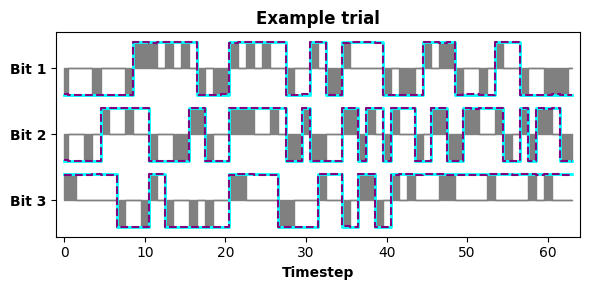

In [ ]:
model, valid_predictions = train_FlipFlop(train_mode=1)

# STEP 2: Find, analyze, and visualize the fixed points of the trained RNN



Searching for fixed points from 1024 initial states.

	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		526 iters
		q = 1.37e-14 +/- 2.34e-14
		dq = 1.58e-14 +/- 2.79e-13
		learning rate = 1.96e+01
		avg iter time = 4.23e-03 sec
	Identified 27 unique fixed points.
		initial_states: 0 outliers detected (of 1024).
		fixed points: 0 outliers detected (of 27).
	Computing recurrent Jacobian at 27 unique fixed points.
	Computing input Jacobian at 27 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



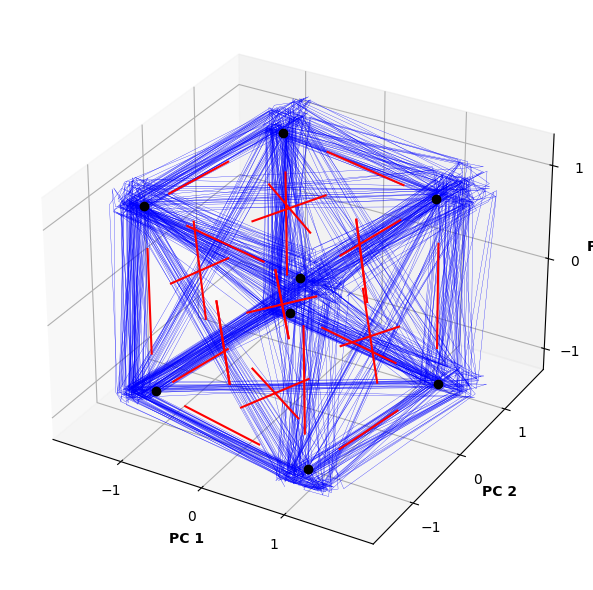

In [ ]:
find_fixed_points(model, valid_predictions)